# ----------------------------------
# Import modules
# ----------------------------------

In [15]:
import os
import requests                      # HTTP client for API calls
import pandas as pd                  # Tabular data handling
from datetime import datetime        # Datetime handling
from typing import Iterable, Optional, Dict, Union
import matplotlib.pyplot as plt
%pip install yfinance
import yfinance as yf
from src.exchange_rates import get_share_prices_2
from src.debug_print import debug_print
from src.plot_shares import plot_candles_with_volatility
from src.plot_shares_ROI import plot_candles_with_volatility_and_target as plt_vol_trg
from src.plot_shares_ROI2 import plot_candles_volatility_volume_roi as ROI
from src.fetch_lse_tickers import get_ftse100

Note: you may need to restart the kernel to use updated packages.


# ----------------------------------
# Import functions
# ----------------------------------

In [16]:

from src.debug_print import debug_print
from src.exchange_rates import get_exchange_rates, get_crypto_prices, get_fx_and_crypto, get_share_prices, convert_prices_to_base_currency, plot_fx_timeseries

# ----------------------------------
# Set up variables
# ----------------------------------

In [17]:
base_currency = "GBP"
target_currencies = ["USD", "GBP", "EUR", "JPY"]
cryptos = ["BTC", "ETH"]
shares = ['AAPL', 'RR.L', 'MSFT', 'NVDA', 'LDO.MI','4816.T']

start_date = datetime(2024, 6, 1)
end_date = pd.Timestamp.today().normalize()

try:
    ftse100 = get_ftse100()
    ftse100["Yahoo_Ticker"] = ftse100["Ticker"] + ".L"

    shares_lse = ftse100["Yahoo_Ticker"].to_list()


except Exception as e:
    print(f"ERROR in ftse100 {type(e).__name__}: {e}")

# --------------------------------
# SHARES' PRICES
# --------------------------------

In [18]:
try:
    df_shares2 = get_share_prices_2(
    tickers=shares_lse,
    start=start_date,
    end=end_date,
    base_currency = base_currency,
    vol_window = 20,
)

    print(f"{debug_print()} get_share_prices_2:\n{df_shares2}")
except Exception as e:
    print(f"{debug_print()} [FAILED] running get_share_prices_2 {type(e).__name__}: {e} ")


[DEBUG] File: C:\Users\ingca\AppData\Local\Temp\ipykernel_10156\2516834727.py, Function: <module>, Line: 10
None get_share_prices_2:
ACTION     III.L_GBP→GBP                  ... WTB.L_GBP→GBP                    
CURRENCY             GBP                  ...           GBP                    
METRIC               LOW    HIGH   CLOSE  ...         RANGE VOLATILITY   VOLUME
Date                                      ...                                  
2024-06-03   2887.000000  2929.0  2926.0  ...     58.560059        NaN   740514
2024-06-04   2915.000000  2959.0  2942.0  ...     61.000000        NaN   864181
2024-06-05   2912.243896  2969.0  2959.0  ...     35.000000        NaN   729840
2024-06-06   2922.000000  2986.0  2952.0  ...     36.000000        NaN   577521
2024-06-07   2903.000000  2971.0  2926.0  ...     58.000000        NaN   829694
...                  ...     ...     ...  ...           ...        ...      ...
2025-12-23   3224.000000  3287.0  3235.0  ...     34.500000   0.032

# ----------- PLOT SHARE ---------------

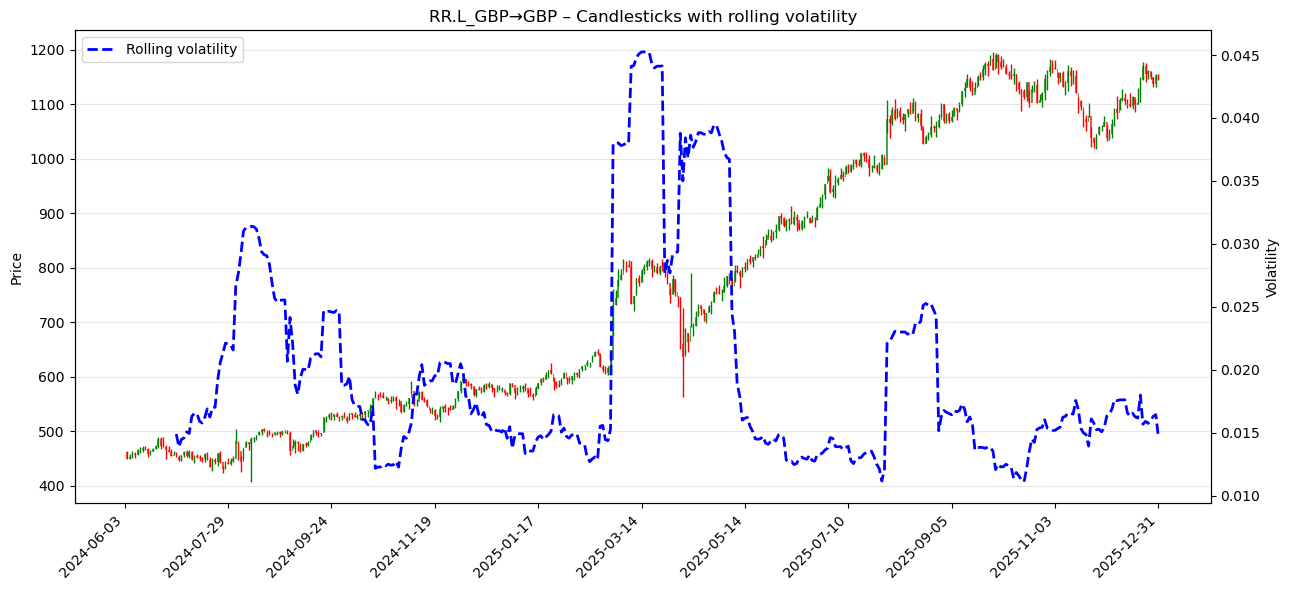

In [19]:
try:
    actions_list   = df_shares2.columns.get_level_values("ACTION").unique().to_list()
    currencies_list = df_shares2.columns.get_level_values("CURRENCY").unique()
    metrics   = df_shares2.columns.get_level_values("METRIC").unique()

    plot_candles_with_volatility(
        df=df_shares2,
        actions=['RR.L_GBP→GBP'],
        start=df_shares2.index.min(),
        end=df_shares2.index.max()
    )
except Exception as e:
    print(f"{debug_print()} [FAILED] PLOT SHARE {type(e).__name__}: {e} ") 

# ----------- PLOT SHARE - plot_candles_with_volatility_and_target ---------------


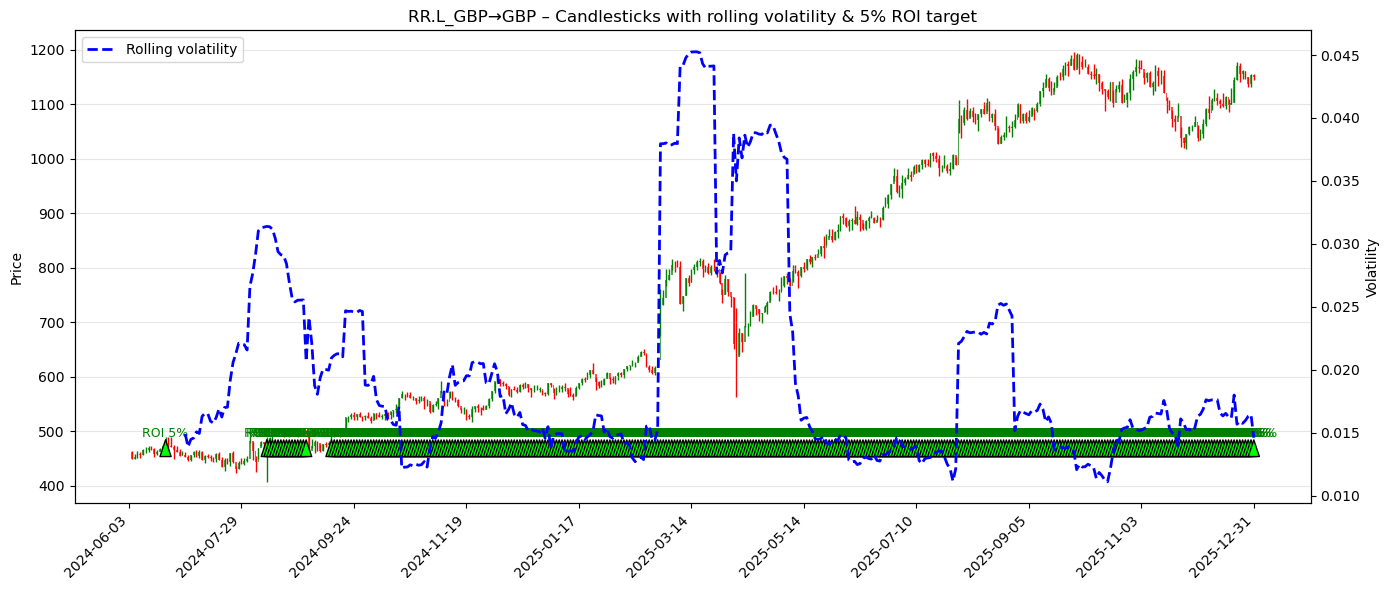

In [20]:
try:
    actions_list   = df_shares2.columns.get_level_values("ACTION").unique().to_list()
    currencies_list = df_shares2.columns.get_level_values("CURRENCY").unique()
    metrics   = df_shares2.columns.get_level_values("METRIC").unique()

    plt_vol_trg(
        df=df_shares2,
        actions=['RR.L_GBP→GBP'],
        start=df_shares2.index.min(),
        end=df_shares2.index.max()
    )
except Exception as e:
    print(f"{debug_print()} [FAILED] plt_vol_trg {type(e).__name__}: {e} ") 

# ----------- PLOT SHARE - plot_candles_volatility_volume_roi ---------------


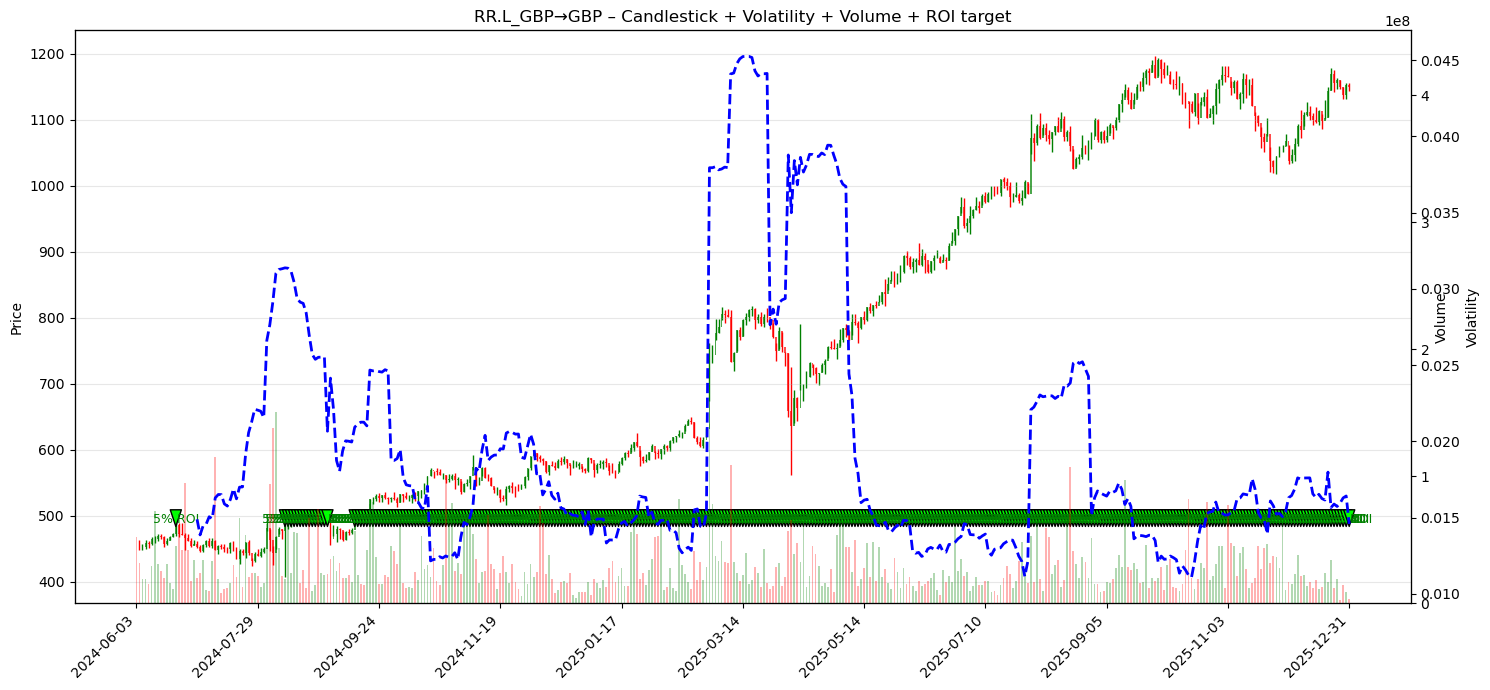

In [21]:
try:
    actions_list   = df_shares2.columns.get_level_values("ACTION").unique().to_list()
    currencies_list = df_shares2.columns.get_level_values("CURRENCY").unique()
    metrics   = df_shares2.columns.get_level_values("METRIC").unique()

    ROI(
        df=df_shares2,
        actions=['RR.L_GBP→GBP'],
        start=df_shares2.index.min(),
        end=df_shares2.index.max()
    )
except Exception as e:
    print(f"{debug_print()} [FAILED] plot_candles_volatility_volume_roi {type(e).__name__}: {e} ")
